## Notebook relaying notes about glider processing and steps that will be incorporated into KiwiGlider package.

### What's needed in the processing of glider data...

We will essentially use pyglider to create compliant real-time netCDF files of casts, but then also start processing the data similar to IMOS in Australia, and borrowing steps from GEOMAR's matlab toolbox, to generate a netCDF/xarray/zarr dataset that can be used by glidertools.
Additional functionality might include: predicted tides, day/night cycle (TBD).

For now, the steps seem to be

1. Load raw data with dbdreader
2. Define what is a cast (alternatives between pyglider, GEOMAR, SOCIB, m_tot_num_inflections)
3. Get best form of lat/lon and gps lat/lon fixes.
4. Post-process science data:
    * T/S alignment
    * Chl day/night
    * O2 temp-alignment
    * QArtode flags for bad values
5. Generate flight model to get lon/lat for all observations, and speed for MicroRider?
6. Export to xarray, save netCDF, possibly Zarr.

------------------------------------------------------------------

As a walk-through of the processing we will be using deployment 0028 on the NE Shelf. This deployment went deep (~1000m), and has most instruments (CTD, O2, Eco-triplet, PAR sensor). The data from the LOPC and Microrider are stored separately on those devices, and so separate scripts are necessary to process those data.

#### Step 1: Load raw data w/ dbd reader
This part is pretty straightforward, once the package is installed (n.b. requires access to C compiler, requires admin rights for windows install). We start by importing packages, and then loading the data in the "raw" directory. In the final package we'll be assuming the following directory tree:

- raw/
    - .EBD, .DBD files
    - cache/
        - .CAC files
- proc/


In [1]:
# Set up environment.
import numpy as np
import scipy as sc
from datetime import datetime, timedelta, UTC
import gsw
try:
    import dbdreader
except ModuleNotFoundError:
    print("Cannot find dbdreader... will not read raw data.")

from matplotlib import pyplot as plt
from netCDF4 import Dataset
import os
import platform

if platform.system() == "Windows":
    print("ok")
    rootDir = 'c:/Users/deverneila/Desktop/'
elif platform.system() == "Linux":
    rootDir = "/mnt/c/Users/deverneila/Desktop/"
#rootDir = "/mnt/c/Users/deverneila/Desktop/"
glidDir = rootDir + "Glider_stuff/"
curDir = glidDir + "Data_Paper/"
batDir = rootDir + "Data/BATHY/"
bFile = batDir + "to_Qdrive/bath_EPSG3994_pluslonlat.nc"
LandPatch = np.load(batDir+"LandPatch.npy",allow_pickle=True)

datDir = glidDir + "Copy_Glider_Data/0028/raw/raw"


%matplotlib inline


In [2]:
# Load DBD/EBD data
# Create multifile DBD object
os.chdir(datDir)
# GEOMAR package loads D/MBD files (main), and E/NBD files (science)
# 
mDBD = dbdreader.MultiDBD("*.[DE]BD",cacheDir="cache/")

# Print list of scientific variables
SciVars = mDBD.parameterNames['sci']
nVars = len(SciVars)
strd = 5
print("List of scientific variables:")
for iV in np.arange(0,nVars,step=strd):
    print([f"{x}" for x in SciVars[iV:iV+strd]])

# Test for presence of extra variables:
testVar = ["oxy","bsipar","flbbcd","","bb3slo",""]
for var in SciVars:
    if "oxy" in var:
        print("Found oxygen")
        break
for var in SciVars:
    if "bsipar" in var:
        print("Found PAR")
        break
for var in SciVars:
    if "flbbcd" in var:
        print("Found eco triplet")
        break
for var in SciVars:
    if "bb3slo" in var:
        print("Found multi-spectral backscatter")
        break
    

File 06660045.EBD could not be loaded


List of scientific variables:
['sci_ad2cp_file_state', 'sci_badd_error', 'sci_badd_finished', 'sci_badd_n_tries_to_connect', 'sci_badd_power_on']
['sci_badd_target_range', 'sci_bb3slo_b470_ref', 'sci_bb3slo_b470_scaled', 'sci_bb3slo_b470_sig', 'sci_bb3slo_b532_ref']
['sci_bb3slo_b532_scaled', 'sci_bb3slo_b532_sig', 'sci_bb3slo_b660_ref', 'sci_bb3slo_b660_scaled', 'sci_bb3slo_b660_sig']
['sci_bb3slo_is_installed', 'sci_bb3slo_temp', 'sci_bb3slo_timestamp', 'sci_bsipar_is_installed', 'sci_bsipar_par']
['sci_bsipar_sensor_volts', 'sci_bsipar_supply_volts', 'sci_bsipar_temp', 'sci_bsipar_timestamp', 'sci_ctd41cp_is_installed']
['sci_ctd41cp_timestamp', 'sci_flbbcd_bb_ref', 'sci_flbbcd_bb_sig', 'sci_flbbcd_bb_units', 'sci_flbbcd_cdom_ref']
['sci_flbbcd_cdom_sig', 'sci_flbbcd_cdom_units', 'sci_flbbcd_chlor_ref', 'sci_flbbcd_chlor_sig', 'sci_flbbcd_chlor_units']
['sci_flbbcd_is_installed', 'sci_flbbcd_therm', 'sci_flbbcd_timestamp', 'sci_m_disk_free', 'sci_m_disk_usage']
['sci_m_free_heap', '

In [3]:
# Extract pressure, temp, cond, machine Time, Depth. Do a first time-sort...
pTime, pDat = mDBD.get('sci_water_pressure')
pSort = np.argsort(pTime)
pTime = pTime[pSort]
pDat = pDat[pSort]

tTime, tDat = mDBD.get('sci_water_temp')
tSort = np.argsort(tTime)
tTime = tTime[tSort]
tDat = tDat[tSort]

cTime, cDat = mDBD.get('sci_water_cond')
cSort = np.argsort(cTime)
cTime = cTime[cSort]
cDat = cDat[cSort]

mTime, _ = mDBD.get('m_present_time')
mSort = np.argsort(mTime)
mTime = mTime[mSort]

mDepTime, mDep = mDBD.get('m_depth')
dSort = np.argsort(mDepTime)
mDepTime = mDepTime[dSort]
mDep = mDep[dSort]


In [ ]:
# All lon/lats necessary for processing of positions...
loTime, loDat = mDBD.get('m_lon')
laTime, laDat = mDBD.get('m_lat')
if np.nansum(loTime==laTime) == len(loTime):
    print("m_lon and m_lat have same timestamps, deleting copy...")
    del laTime
lSort = np.argsort(loTime)
loTime = loTime[lSort]
loDat = loDat[lSort]
laDat = laDat[lSort]

loGTime, loGDat = mDBD.get('m_gps_lon')
laGTime, laGDat = mDBD.get('m_gps_lat')
if np.nansum(loGTime==laGTime) == len(loGTime):
    print("m_gps_lon and m_gps_lat have same timestamps, deleting copy...")
    del laGTime
lSort = np.argsort(loGTime)
loGTime = loGTime[lSort]
loGDat = loGDat[lSort]
laGDat = laGDat[lSort]

loIVTime, loIVDat = mDBD.get('m_gps_invalid_lon')
laIVTime, laIVDat = mDBD.get('m_gps_invalid_lat')
if np.nansum(loIVTime==laIVTime) == len(loIVTime):
    print("m_gps_invalid_lon and m_gps_invalid_lat have same timestamps, deleting copy...")
    del laIVTime
lSort = np.argsort(loIVTime)
loIVTime = loIVTime[lSort]
loIVDat = loIVDat[lSort]
laIVDat = laIVDat[lSort]

loFTime, loFDat = mDBD.get('m_gps_toofar_lon')
laFTime, laFDat = mDBD.get('m_gps_toofar_lat')
if np.nansum(loFTime==laFTime) == len(loFTime):
    print("m_gps_toofar_lon and m_gps_toofar_lat have same timestamps, deleting copy...")
    del laFTime
lSort = np.argsort(loFTime)
loFTime = loFTime[lSort]
loFDat = loFDat[lSort]
laFDat = laFDat[lSort]

loIGTime, loIGDat = mDBD.get('m_gps_ignored_lon')
laIGTime, laIGDat = mDBD.get('m_gps_ignored_lat')
if np.nansum(loIGTime==laIGTime) == len(loIGTime):
    print("m_gps_ignored_lon and m_gps_ignored_lat have same timestamps, deleting copy...")
    del laIGTime
lSort = np.argsort(loIGTime)
loIGTime = loIGTime[lSort]
loIGDat = loIGDat[lSort]
laIGDat = laIGDat[lSort]


m_lon and m_lat have same timestamps, deleting copy...
m_gps_lon and m_gps_lat have same timestamps, deleting copy...
m_gps_invalid_lon and m_gps_invalid_lat have same timestamps, deleting copy...
m_gps_toofar_lon and m_gps_toofar_lat have same timestamps, deleting copy...
m_gps_ignored_lon and m_gps_ignored_lat have same timestamps, deleting copy...


In [6]:
([(loTime,loDat),(laTime,laDat),(loGTime,loGDat),(laGTime,laGDat),(loIVTime,loIVDat),(laIVTime,laIVDat),
(loFTime,loFDat),(laFTime,laFDat),(loIGTime,loIGDat),(laIGTime,laIGDat)]) = mDBD.get('m_lon','m_lat',
'm_gps_lon','m_gps_lat','m_gps_invalid_lon','m_gps_invalid_lat','m_gps_toofar_lon','m_gps_toofar_lat',
'm_gps_ignored_lon','m_gps_ignored_lat')


In [5]:
# Load GPS times
_, m_gps_utc_yr = mDBD.get('m_gps_utc_year')
_, m_gps_utc_mon = mDBD.get('m_gps_utc_month')
_, m_gps_utc_day = mDBD.get('m_gps_utc_day')
_, m_gps_utc_hr = mDBD.get('m_gps_utc_hour')
_, m_gps_utc_min = mDBD.get('m_gps_utc_minute')
_, m_gps_utc_sec = mDBD.get('m_gps_utc_second')


In [6]:
# From GEOMAR:
# Test to see if m_present_time doesn't span >1year...
if (mTime[-1]-mTime[0]) > 86400*365:
    print("m_present_time span > 1yr! Might have more than 1 deployment's data here...")
else:
    print("m_present_time does not span > 1yr...")
# Check that the shapes are all the same
if pDat.shape == tDat.shape:
    print("Pressure and temperature sizes match!")
    if pDat.shape == cDat.shape:
        print("Pressure and conductivity sizes match!")
        print("All three have same shape!")
    else:
        print("Pressure, Temp sizes match, not conductivity...")
elif pDat.shape == cDat.shape:
    print("Pressure, Temp sizes don't match, but Pressure, condctivity do...")
else:
    if tDat.shape == cDat.shape:
        print("Temp,Cond sizes match, but not with Pressure...")
    else:
        print("None of the three match!")



m_present_time does not span > 1yr...
Pressure and temperature sizes match!
Pressure and conductivity sizes match!
All three have same shape!


In [7]:
# Remove times with obvious time gaps...
#gapTol = 5 # tolerance of 5 day gap in pressure data
#print(f"Detecting gaps of {gapTol} days... will remove smaller dataset if detected [assumes only 1 gap]")
#indGap = np.where(np.diff(pTime)>gapTol*86400)
#pTime_bak = pTime.copy()
#pDat_bak = pDat.copy()
#if indGap[0].size == 0:
#    print("No gaps in pressure data > 5 days")
#elif indGap[0].size == 1:
#    if (indGap[0][0] > len(pTime)/2):
#        pTime = pTime[:indGap[0][0]+1]
#        pDat = pDat[:indGap[0][0]+1]
#        # Do the same for other CTD variables...
#        cTime = cTime[:indGap[0][0]+1]
#        cDat = cDat[:indGap[0][0]+1]
#        tTime = tTime[:indGap[0][0]+1]
#        tDat = tDat[:indGap[0][0]+1]
#    else:
#        pTime = pTime[indGap[0][0]+1:]
#        pDat = pDat[indGap[0][0]+1:]
#        cTime = cTime[indGap[0][0]+1:]
#        cDat = cDat[indGap[0][0]+1:]
#        tTime = tTime[indGap[0][0]+1:]
#        tDat = tDat[indGap[0][0]+1:]
#else:
#    print("Multiple large gaps!")

#plt.figure(1)
#plt.plot(pTime,-pDat*10,'.')


------------------------------------------
### Step 2: Correct lon/lat

QC on GPS locations, correct longitude and latitude


In [8]:
# Process to get lat/lon positions...
# First off: remove Webb dummy values (69696969)
# badVal = 69696969
loDat[loDat==69696969] = np.nan
laDat[laDat==69696969] = np.nan
loGDat[loGDat==69696969] = np.nan
laGDat[laGDat==69696969] = np.nan
loIVDat[loIVDat==69696969] = np.nan
laIVDat[laIVDat==69696969] = np.nan
loFDat[loFDat==69696969] = np.nan
laFDat[laFDat==69696969] = np.nan
loIGDat[loIGDat==69696969] = np.nan
laIGDat[laIGDat==69696969] = np.nan


In [9]:
# Second: remove values outside of -361:lon:361 and -90:lat:90
lo_range = [-361, 361]
la_range = [-90, 90]
# lon/lat
indB = np.where((loDat<lo_range[0]) | (loDat>lo_range[1]) | (laDat<la_range[0]) | (laDat>la_range[1]))[0]
loDat[indB] = np.nan
laDat[indB] = np.nan
# gps lon/lat
indB = np.where((loGDat<lo_range[0]) | (loGDat>lo_range[1]) | (laGDat<la_range[0]) | (laGDat>la_range[1]))[0]
loGDat[indB] = np.nan
laGDat[indB] = np.nan
# Invalid lon/lat
indB = np.where((loIVDat<lo_range[0]) | (loIVDat>lo_range[1]) | (laIVDat<la_range[0]) | (laIVDat>la_range[1]))[0]
loIVDat[indB] = np.nan
laIVDat[indB] = np.nan
# Faroff lon/lat
indB = np.where((loFDat<lo_range[0]) | (loFDat>lo_range[1]) | (laFDat<la_range[0]) | (laFDat>la_range[1]))[0]
loFDat[indB] = np.nan
laFDat[indB] = np.nan
# Ignored lon/lat
indB = np.where((loIGDat<lo_range[0]) | (loIGDat>lo_range[1]) | (laIGDat<la_range[0]) | (laIGDat>la_range[1]))[0]
loIGDat[indB] = np.nan
laIGDat[indB] = np.nan


In [10]:
# Third: Compare GPS time with m_present_time...
# QC to remove where all GPS components == 0:
indG = []
for ind, blah in enumerate(zip(m_gps_utc_yr,m_gps_utc_mon,m_gps_utc_day,m_gps_utc_hr,m_gps_utc_min,m_gps_utc_sec)):
    if np.nansum(blah) == 0:
        print(f"Bad value at {ind}...")
    else:
        indG.append(ind)
# Keep only good indices...
m_gps_utc_yr = m_gps_utc_yr[indG]
m_gps_utc_mon = m_gps_utc_mon[indG]
m_gps_utc_day = m_gps_utc_day[indG]
m_gps_utc_hr = m_gps_utc_hr[indG]
m_gps_utc_min = m_gps_utc_min[indG]
m_gps_utc_sec = m_gps_utc_sec[indG]
if len(m_gps_utc_yr) == len(loGTime):
    print("Successfully removed extraneous timestamps")
else:
    print("Lengths do not match, should double-check...")
# Construct m_gps_time from gps components...
m_gps_UTC = np.asarray([datetime(int(x)+2000,int(y),int(z),int(a),int(b),int(c),tzinfo=UTC)
                        if y > 0 else np.nan for x,y,z,a,b,c in
                        zip(m_gps_utc_yr,m_gps_utc_mon,m_gps_utc_day,
                            m_gps_utc_hr,m_gps_utc_min,m_gps_utc_sec)])
# Sort m_gps_UTC...
mSort = np.argsort(m_gps_UTC)
m_gps_UTC = m_gps_UTC[mSort]

m_gps_Timestamp = np.asarray([x.timestamp() if isinstance(x,datetime) else np.nan for x in m_gps_UTC])
# Find, remove all timestamps > 1 min difference
dTime = loGTime - m_gps_Timestamp
indOld = np.where(dTime>(60))[0]
print(f"Found {len(indOld):d} timestamps with GPS fix > 1 min old..., NaN out GPS lon/lat")
loGDat[indOld] = np.nan
laGDat[indOld] = np.nan

Bad value at 3091...
Successfully removed extraneous timestamps
Found 3 timestamps with GPS fix > 1 min old..., NaN out GPS lon/lat


In [11]:
# Fourth: Go through invalid, ignored, toofar and remove overlaps...
for IgT in loIGTime:
    tem = np.where(loGTime==IgT)[0]
    if tem.size > 0:
        print(f"Found time overlap with ignored gps time.")
        loGDat[tem] = np.nan
        laGDat[tem] = np.nan

for IvT in loIVTime:
    tem = np.where(loGTime==IvT)[0]
    if tem.size > 0:
        print(f"Found time overlap with invalid gps time")
        loGDat[tem] = np.nan
        laGDat[tem] = np.nan

for FT in loFTime:
    tem = np.where(loGTime==FT)[0]
    if tem.size > 0:
        print(f"Found time overlap with toofar gps time")
        loGDat[tem] = np.nan
        laGDat[tem] = np.nan


Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gps time.
Found time overlap with ignored gp

In [12]:
# Fifth: Remove GPS positions where apparent velocity is > 5m/s
velMax = 5
import gsw

# Back-up of loGDat, laGDat:
loGDat_back = loGDat.copy()
laGDat_back = laGDat.copy()

# Get valid values
indG = np.where((~np.isnan(loGDat)) & (loGDat != -999))[0]
# Calculate distance (in m) and divide by s to get m/s
gps_dist = gsw.distance(loGDat[indG],laGDat[indG])
gps_vel = gps_dist/np.diff(loGTime[indG])
bad = np.where(gps_vel>velMax)[0]
toNaN = []
iter = 0
while bad.size > 0:
    loGDat[indG[bad[0]+1]] = np.nan
    laGDat[indG[bad[0]+1]] = np.nan
    indG = np.where(~np.isnan(loGDat) & (loGDat != -999))[0]
    gps_vel = gsw.distance(loGDat[indG],laGDat[indG])/np.diff(loGTime[indG])
    bad = np.where(gps_vel>velMax)[0]
    iter += 1
    if iter>1e5:
        print("Loop has executed 1e5 times, breaking out of while loop...")
        break

print(f"Executed loop {iter} times")

Executed loop 86 times


In [13]:
# Sixth. Now assume all "trusted" GPS fixes are good, but remove invalid, ignored, toofar, or dead-reckoned are >20 miles [32km]
indG = np.where((~np.isnan(loGDat)) & (loGDat != -999))[0]
# Cycle through "invalid" lon/lats
for ind, txy in enumerate(zip(loIVTime,loIVDat,laIVDat)):
    ttime,tlon,tlat = txy
    tind = np.searchsorted(loGTime[indG],ttime)
    for test in range(tind-1,tind+2):        
        # See if distance is ever > 32 km...
        if gsw.distance([loGDat[indG[test]],tlon], [laGDat[indG[test]],tlat])/1000 > 32:
            loIVDat[ind] = np.nan
            laIVDat[ind] = np.nan

# Cycle through ignored lon/lat
for ind, txy in enumerate(zip(loIGTime,loIGDat,laIGDat)):
    ttime,tlon,tlat = txy
    tind = np.searchsorted(loGTime[indG],ttime)
    for test in range(tind-1,tind+2):        
        # See if distance is ever > 32 km...
        if gsw.distance([loGDat[indG[test]],tlon], [laGDat[indG[test]],tlat])/1000 > 32:
            loIGDat[ind] = np.nan
            laIGDat[ind] = np.nan

# Cycle through toofar
for ind, txy in enumerate(zip(loFTime,loFDat,laFDat)):
    ttime,tlon,tlat = txy
    tind = np.searchsorted(loGTime[indG],ttime)
    for test in range(tind-1,tind+2):        
        # See if distance is ever > 32 km...
        if gsw.distance([loGDat[indG[test]],tlon], [laGDat[indG[test]],tlat])/1000 > 32:
            loFDat[ind] = np.nan
            laFDat[ind] = np.nan

# Cycle GPS to get nearest dead-reckoned, make sure none are too far away...
# So, there SHOULD be an identical timestamp in m_lon for each GPS timestamp... let's double check this...
found = 0
for ind, x in enumerate(loGTime):
    if (np.where(loTime==x)[0]).size > 0:
        found += 1
if found == len(loGTime):
    print("Found matching timestamps for all GPS positions in dead-reckoned dataset.")
else:
    print("Some GPS positions do not have matching timestamp in dead-reckoned... should check this manually!")

# Remove dead-reckoned gps fixes that are 20 miles 
for ind, txy in enumerate(zip(loGTime,loGDat,laGDat)):
    # Find where m_lon matches up...
    ttime,tlon,tlat = txy
    tind = np.where(loTime==ttime)[0]
    #print(tind)
    if (~np.isnan(tlon)) & (~np.isnan(tlat)):
        dist = gsw.distance(np.array([tlon,loDat[tind][0]]),
                            np.array([tlat,laDat[tind][0]]))/1000
        if dist > 32:
            print("Found point {dist} km away! Removing from m_lon/m_lat")
            loDat[tind] = np.nan
            laDat[tind] = np.nan



Found matching timestamps for all GPS positions in dead-reckoned dataset.


In [14]:
# Seven: check for repeated invalid positions, and for each one of those see if it appears in m_lon/m_lat, to within 20cm (approximated as 1e-4/60), then remove.
ii = np.asarray([np.complex64(x,y) for x,y in zip(loIVDat,laIVDat)])
ig = np.asarray([np.complex64(x,y) for x,y in zip(loDat,laDat)])
iiGood = np.where(~np.isnan(ii))
iiGUn = np.unique(ii[iiGood])
for iVun in iiGUn:
    if len(np.where(ii==iVun)[0]) > 1:
        # Find where m_lon/m_lat is <= 1e-4/60
        iclose = np.where(np.abs(ig-iVun)<1e-4/60)[0]
        if iclose.size > 0:
            print(f"Found repeating invalid and matching m_lon/m_lat. Removing...")
            loDat[iclose] = np.nan
            laDat[iclose] = np.nan

# N.B. We will skip the seemingly specific process of finding lone GPS lat values within a 1150 scan radius, error is in GPS not getting good fix, timing out, and using invalid fix for initial/good fix, and then subsequent values are "toofar"%%! Here we'll just check if "too far" applies and move on...
# In the GEOMAR matlab package, this corresponds to lines 489-619 in func_slocum_best_position.m
if loFDat.size == 0:
    print("TooFar data is empty, so assuming time-out error described in GEOMAR package did not occur.")
else:
    print("TooFar is not empty, and so maybe glitch is present that is not being checked...")
    

Found repeating invalid and matching m_lon/m_lat. Removing...
Found repeating invalid and matching m_lon/m_lat. Removing...
Found repeating invalid and matching m_lon/m_lat. Removing...
Found repeating invalid and matching m_lon/m_lat. Removing...
Found repeating invalid and matching m_lon/m_lat. Removing...
Found repeating invalid and matching m_lon/m_lat. Removing...
Found repeating invalid and matching m_lon/m_lat. Removing...
Found repeating invalid and matching m_lon/m_lat. Removing...
Found repeating invalid and matching m_lon/m_lat. Removing...
Found repeating invalid and matching m_lon/m_lat. Removing...
Found repeating invalid and matching m_lon/m_lat. Removing...
Found repeating invalid and matching m_lon/m_lat. Removing...
Found repeating invalid and matching m_lon/m_lat. Removing...
Found repeating invalid and matching m_lon/m_lat. Removing...
Found repeating invalid and matching m_lon/m_lat. Removing...
Found repeating invalid and matching m_lon/m_lat. Removing...
Found re

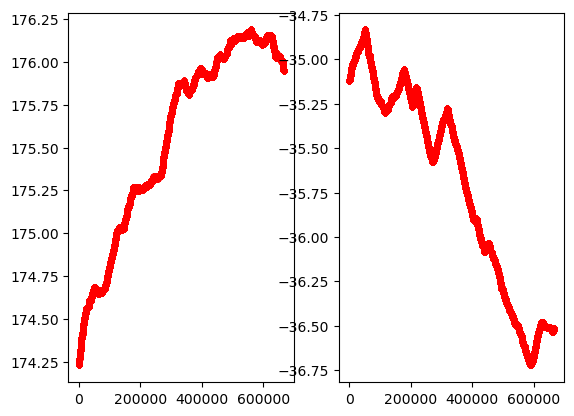

In [15]:
oldLon = loDat
oldLat = laDat
plt.subplot(1,2,1)
plt.plot(oldLon,'r.')
plt.subplot(1,2,2)
plt.plot(oldLat,'r.')


In [16]:
# Correct m_lon, m_lat for dead-reckoning positions between good GPS fixes.
# We take GPS gaps of 10 minutes. The time of surface is ~1min30 after first good GPS fix,
# so if possible use multiple GPS fixes to extrapolate to this time of surface for lon/lat,
# then shift m_lon,m_lat

# Dummy linear function for scipy, extrapolate GPS to surfacing time.
def funcLine(x,a,b):
    return a*x+b

# Use 10-minute gap in GPS timestamps to mean that there is a dive... linearly correct dead-reckoned lon/lat.
indG = np.where((~np.isnan(loGDat)) & (~np.isnan(laGDat)))[0]
tDiff = np.diff(loGTime[indG])
ind10Min = np.where(tDiff>60*10)[0]
#indGDR = np.where((~np.isnan(loDat)) & (~np.isnan(laDat)))[0]

# Loop over ind10Min...
for indPos, indT1 in enumerate(ind10Min):
    #indT1 = ind10Min[0]
    t1 = loGTime[indG[indT1]]
    t2 = loGTime[indG[indT1+1]]
    # Get indices of dead-reckoned times... n.b. lon/lat data might be NaN right at the GPS fix time...
    indD1 = np.where(loTime==t1)[0][0]  # Equivalent to "st"
    indD2 = np.where(loTime==t2)[0][0]  # Equivalent to "en"

    # Get indices of GPS times up to 2 min after re-surface-ish
    t3 = t2 + 60*2.0
    indT3 = np.where(loGTime[indG]<t3)[0][-1]

    # Guess of re-surface time... 1min30sec after t2
    fitTime = t2 + 80

    # Check to see if len(indG[indT2:indT3]) > 5, if so get linear fit, check for veloc > 5m/s; otherwise,
    # use median, if empty is set to NaN.
    if (indT3-indT1)>5:
        # Fit line to GPS lon/lat from indT1+1 to indT3...
        lonVals = loGDat[indG[indT1+1:indT3]]
        latVals = laGDat[indG[indT1+1:indT3]]
        tVals   = loGTime[indG[indT1+1:indT3]]
        # Check to see if speed is >5m/s...
        spd = gsw.distance([lonVals[0],lonVals[-1]],[latVals[0],latVals[-1]])/(tVals[-1]-tVals[0])
        if spd > 5:
            print("Surfaced GPS fixes show > 5m/s... STOP!")
            fitLon = np.nan
            fitLat = np.nan
        else:
            lonLineConst, _ = sc.optimize.curve_fit(funcLine, tVals, lonVals)
            latLineConst, _ = sc.optimize.curve_fit(funcLine, tVals, latVals)
            fitLon = funcLine(fitTime, *lonLineConst)
            fitLat = funcLine(fitTime, *latLineConst)
    elif indT3==indT1:
        print(f"No GPS fixes within 2 minutes of re-surface... setting fit Lon/Lat to NaN")
        fitLon = np.nan
        fitLat = np.nan
    else:
        print("Using median technique for fit Lon/Lat")
        fitLon = np.nanmedian(loGDat[indG[indT1+1:indT3]])
        fitLat = np.nanmedian(laGDat[indG[indT1+1:indT3]])

    # Check to see if not too shallow a dive...
    maxDep = np.nanmax(mDep[np.where((mDepTime>=t1) & (mDepTime<=t2))[0]])

    # Now correct dead-reckoned m_lon/m_lat
    if ((indD2-indD1)>30) & (~np.isnan(fitLon)) & (maxDep>3):
        print(f"Correcting m_lon/m_lat for dive {indPos} out of {len(ind10Min)}")
        #delDR_lat  = laDat[indGDR[indD2]] - laDat[indGDR[indD1]]
        #delDR_lon  = loDat[indGDR[indD2]] - loDat[indGDR[indD1]]
        #delDR_time = loTime[indGDR[indD2]] - loTime[indGDR[indD1]]
    delDR_lat  = laDat[indD2] - laDat[indD1]
    delDR_lon  = loDat[indD2] - loDat[indD1]
    delDR_time = loTime[indD2] - loTime[indD1]

    delG_lat = fitLat - laGDat[indG[indT1]]
    delG_lon = fitLon - loGDat[indG[indT1]]
    #delG_time = loTime[indGDR[indD2]] - loGTime[indG[indT1]]
    delG_time = loTime[indD2] - loGTime[indG[indT1]]

    ddt_DRLat = delDR_lat/delDR_time
    ddt_DRLon = delDR_lon/delDR_time
    ddt_GLat = delG_lat/delG_time
    ddt_GLon = delG_lon/delG_time

    t = loTime[indD1:indD2+1]





Correcting m_lon/m_lat for dive 0 out of 838
Correcting m_lon/m_lat for dive 3 out of 838
Correcting m_lon/m_lat for dive 5 out of 838
Correcting m_lon/m_lat for dive 6 out of 838
Correcting m_lon/m_lat for dive 8 out of 838
Correcting m_lon/m_lat for dive 10 out of 838
Correcting m_lon/m_lat for dive 12 out of 838
Correcting m_lon/m_lat for dive 14 out of 838
Correcting m_lon/m_lat for dive 16 out of 838
Correcting m_lon/m_lat for dive 18 out of 838
Correcting m_lon/m_lat for dive 20 out of 838
Correcting m_lon/m_lat for dive 22 out of 838
Correcting m_lon/m_lat for dive 24 out of 838
Correcting m_lon/m_lat for dive 26 out of 838
Correcting m_lon/m_lat for dive 28 out of 838
Correcting m_lon/m_lat for dive 30 out of 838
Correcting m_lon/m_lat for dive 32 out of 838
Correcting m_lon/m_lat for dive 34 out of 838
Correcting m_lon/m_lat for dive 36 out of 838
Correcting m_lon/m_lat for dive 37 out of 838
Correcting m_lon/m_lat for dive 38 out of 838
Correcting m_lon/m_lat for dive 39 out 

In [17]:
len(~np.isnan(oldLon))


666623

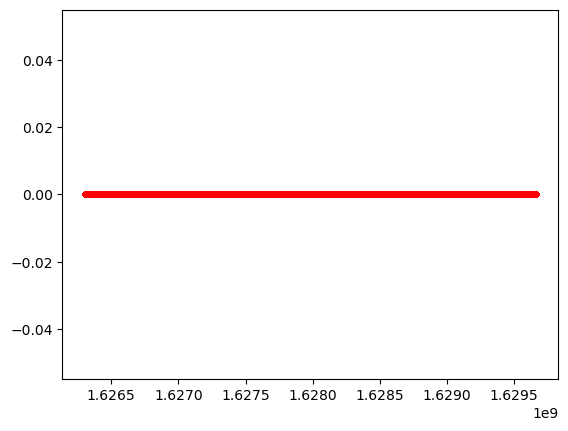

In [18]:
#plt.plot(loTime,oldLon,'r.',markersize=5)
#loTime.shape
#loDat.shape
#plt.plot(loTime,loDat,'b.',markersize=1)
plt.plot(loTime,loDat-oldLon,'.r')

----------------------------------------------

### Step 3: Define a cast

Using loaded pressure data, apply different methodologies to define a cast...

In [19]:
# Now, search for casts...
# Options:
#   PyGlider:
#   GEOMAR:
#   SOCIB:
#   m_

-------------------------------------------------------

### Step 4: Start QC of Science data

3
Min diff is: -22.66046142578125
Max diff is: 708.8215637207031
Mean diff is: -6.11649813705061


11.8

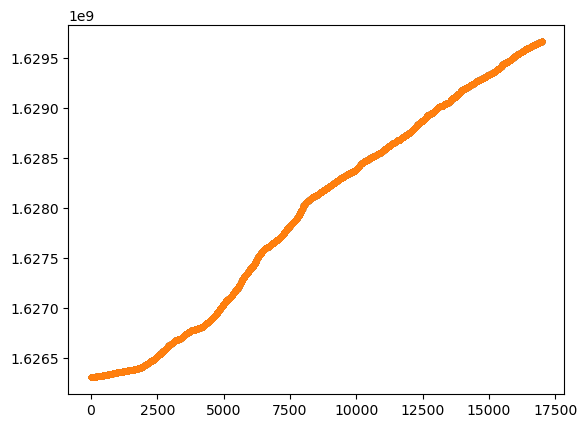

In [20]:
plt.plot(loGTime,'.')
gTime = np.asarray([datetime(int(x)+2000,int(y),int(z),int(a),int(b),int(c),tzinfo=UTC) if y > 0 else np.nan for x,y,z,a,b,c in zip(m_gps_utc_yr,m_gps_utc_mon,m_gps_utc_day,m_gps_utc_hr,m_gps_utc_min,m_gps_utc_sec)])
gDateTime = np.asarray([x.timestamp() if isinstance(x,datetime) else np.nan for x in gTime])
plt.plot(gDateTime,'.')
dTime = np.abs(loGTime - gDateTime)
print(len(np.where(dTime>60)[0]))
print(f"Min diff is: {np.nanmin(loGTime-gDateTime)}")
print(f"Max diff is: {np.nanmax(loGTime-gDateTime)}")
print(f"Mean diff is: {np.nanmean(loGTime-gDateTime)}")
np.nanmean(loGTime-gDateTime)
708/60

All GPS times exist in m_lon timestamps


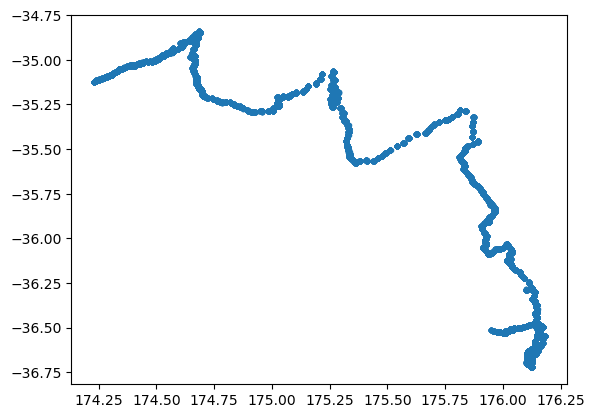

In [21]:
plt.plot(loGDat,laGDat,'.')
plt.plot(loGDat[np.where(dTime>60)[0]],laGDat[np.where(dTime>60)[0]],'.')
loGDat.shape
loDat.shape
lenmatch = 0
for x in loGTime:
    if (np.where(loTime==x)[0]).size > 0:
        lenmatch += 1
if lenmatch == len(loGTime):
    print("All GPS times exist in m_lon timestamps")
